In [4]:
from Fuzzy.FIS1 import FIS1
import concurrent.futures
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import osmnx as ox
import networkx as nx
import requests
import json
from scipy.optimize import curve_fit
from urllib.parse import urljoin
import numpy as np
# import fuzzy logic 
import skfuzzy as fuzz
import skfuzzy.membership as mf
import mm_utils
# for plotting 
import matplotlib.pyplot as plt

In [5]:
# for testing purposes 
# first input in imp 

# speed, heading, PD, HDOP 
matrix_data = np.array([
    [15.7626, 87.56807252, 22.31084837, 0.8],
    [15.7626, 88.70958938, 19.39938780, 0.8],
    [15.7626, 88.12707344, 19.39938780, 0.8],
    [15.7626, 88.80081837, 23.38696383, 0.8],
    [15.7626, 0.33105934, 0.03973635, 0.8],
    [15.7626, 0.02028626, 19.39938780, 0.8]
])

data_temp = matrix_data[1,:]
print(data_temp[0])

15.7626


C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Cov

26.20964836372295
28.267641971646032
28.267650729459007
25.06746506963832
52.49989165629695
52.506812754972735


C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


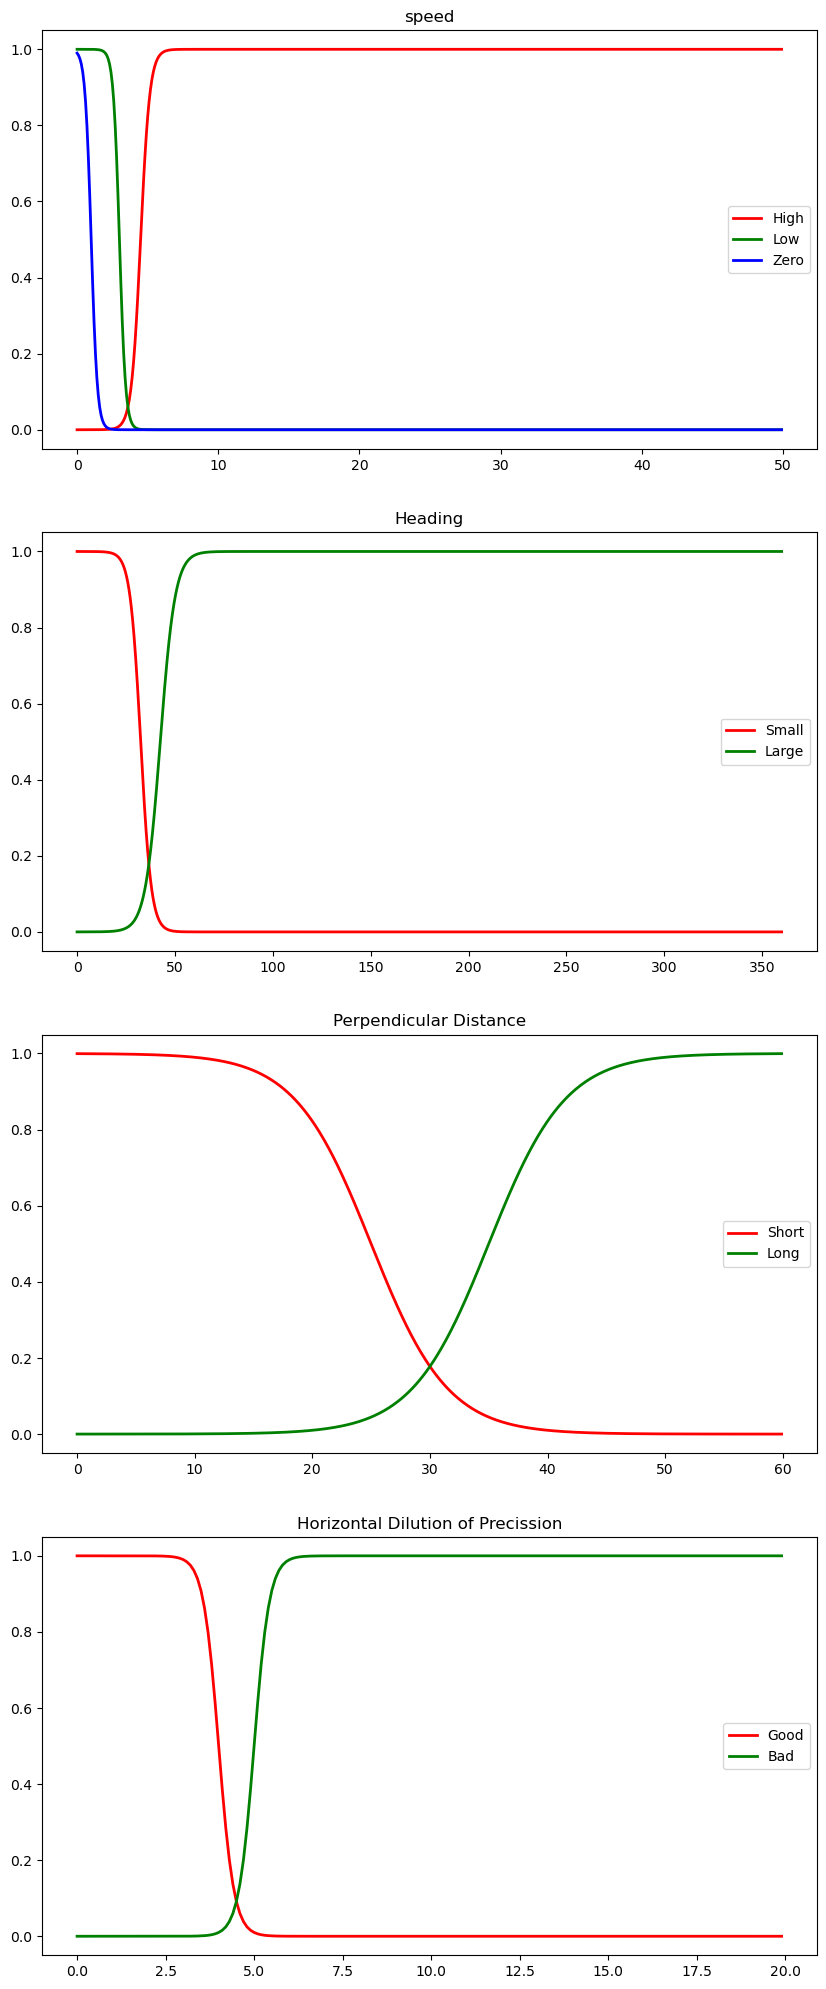

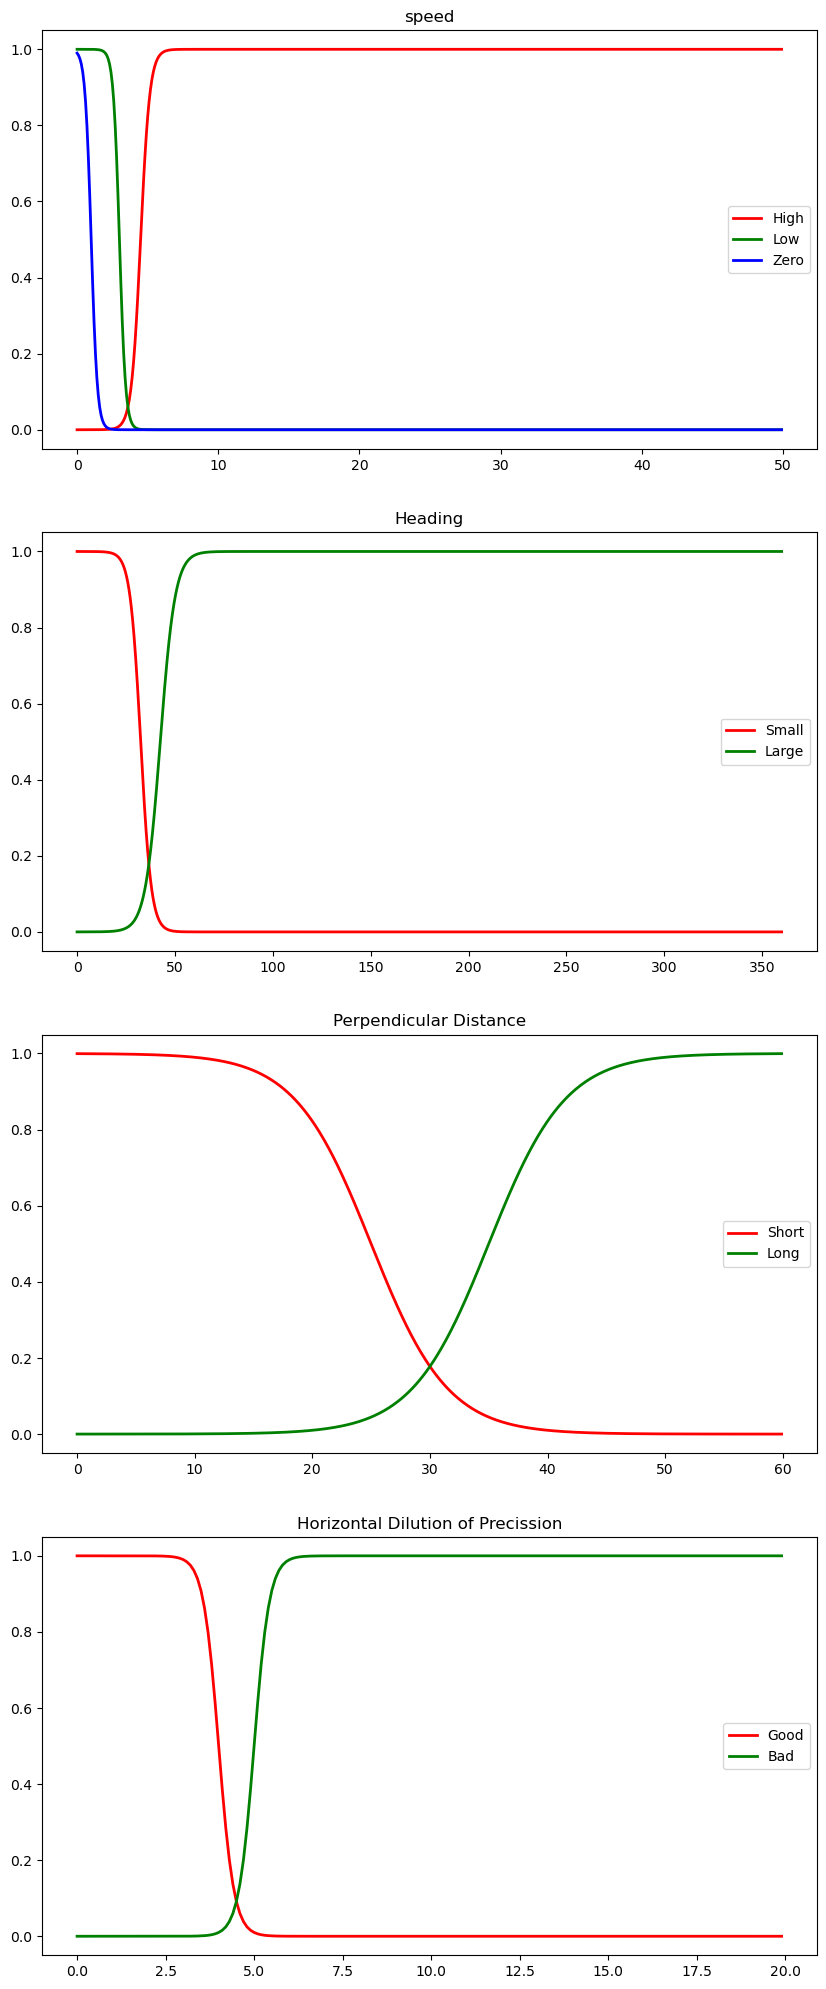

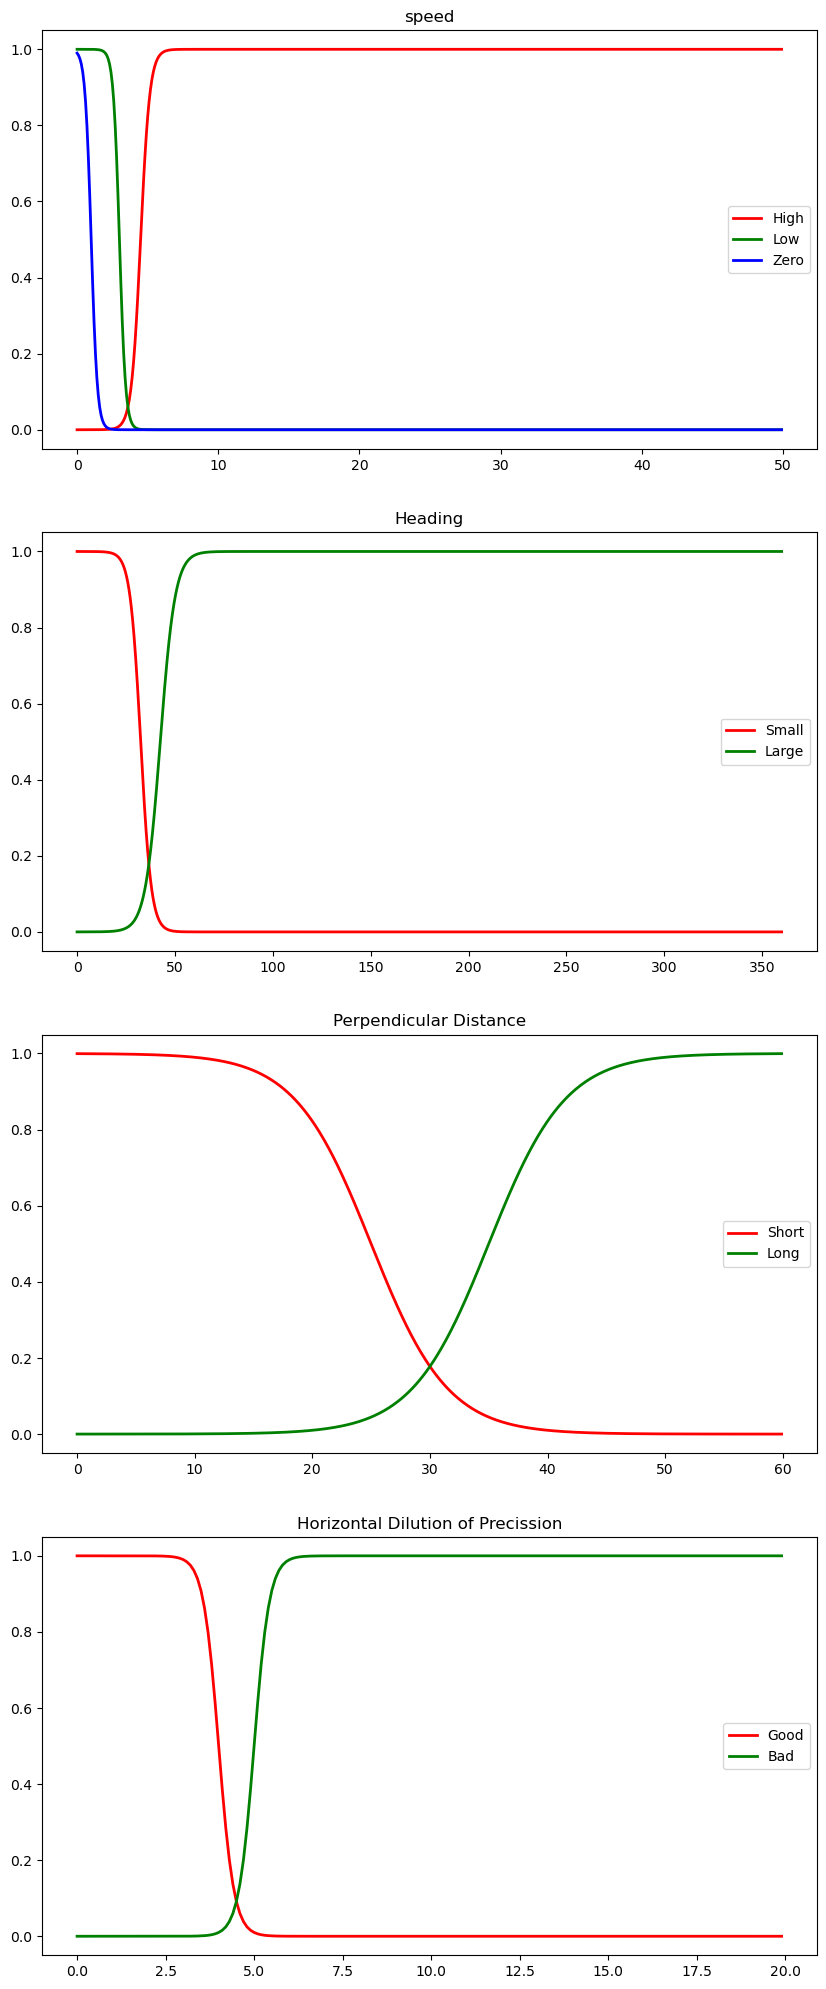

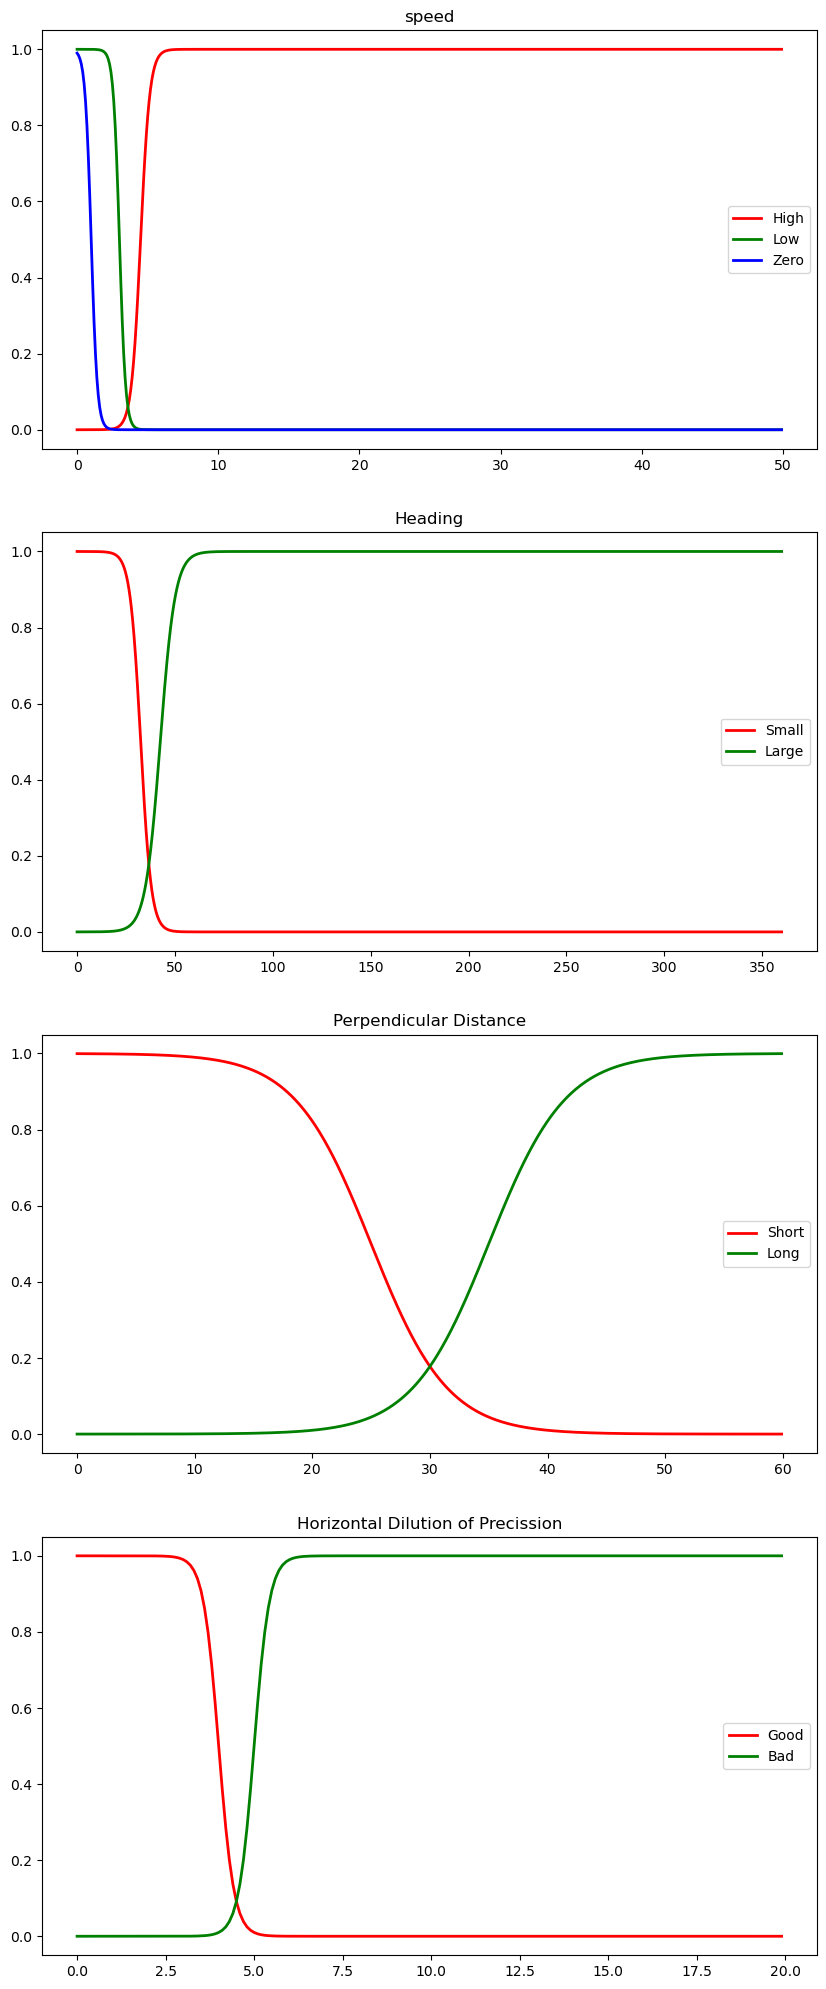

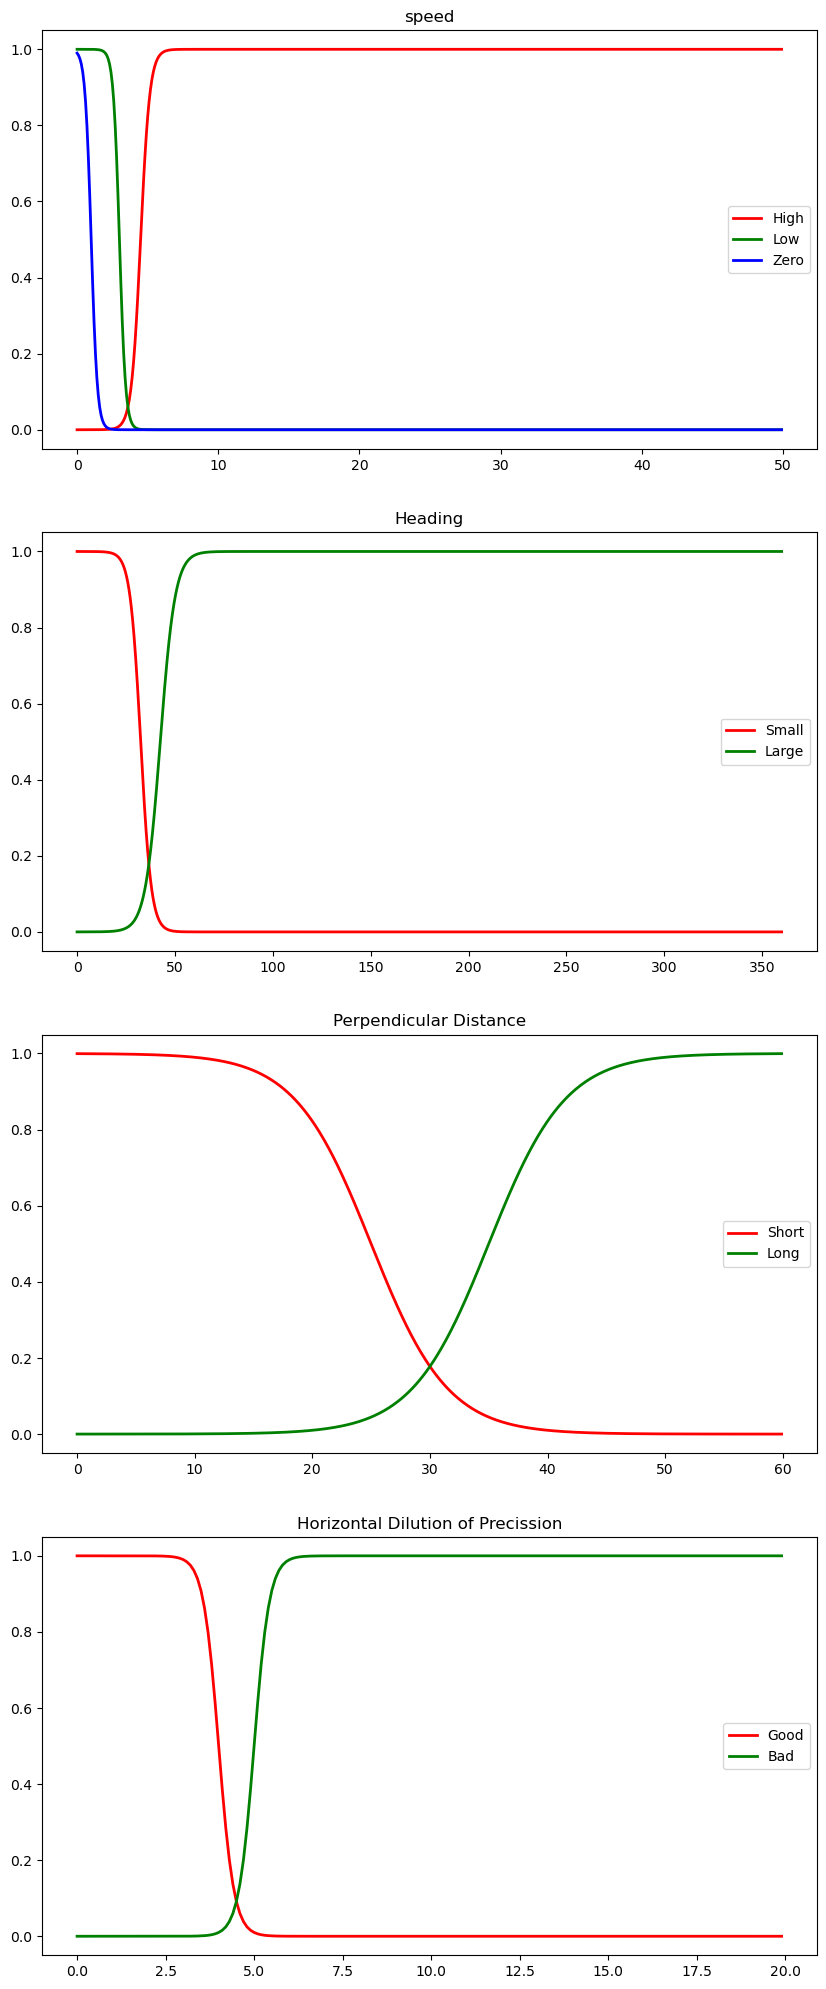

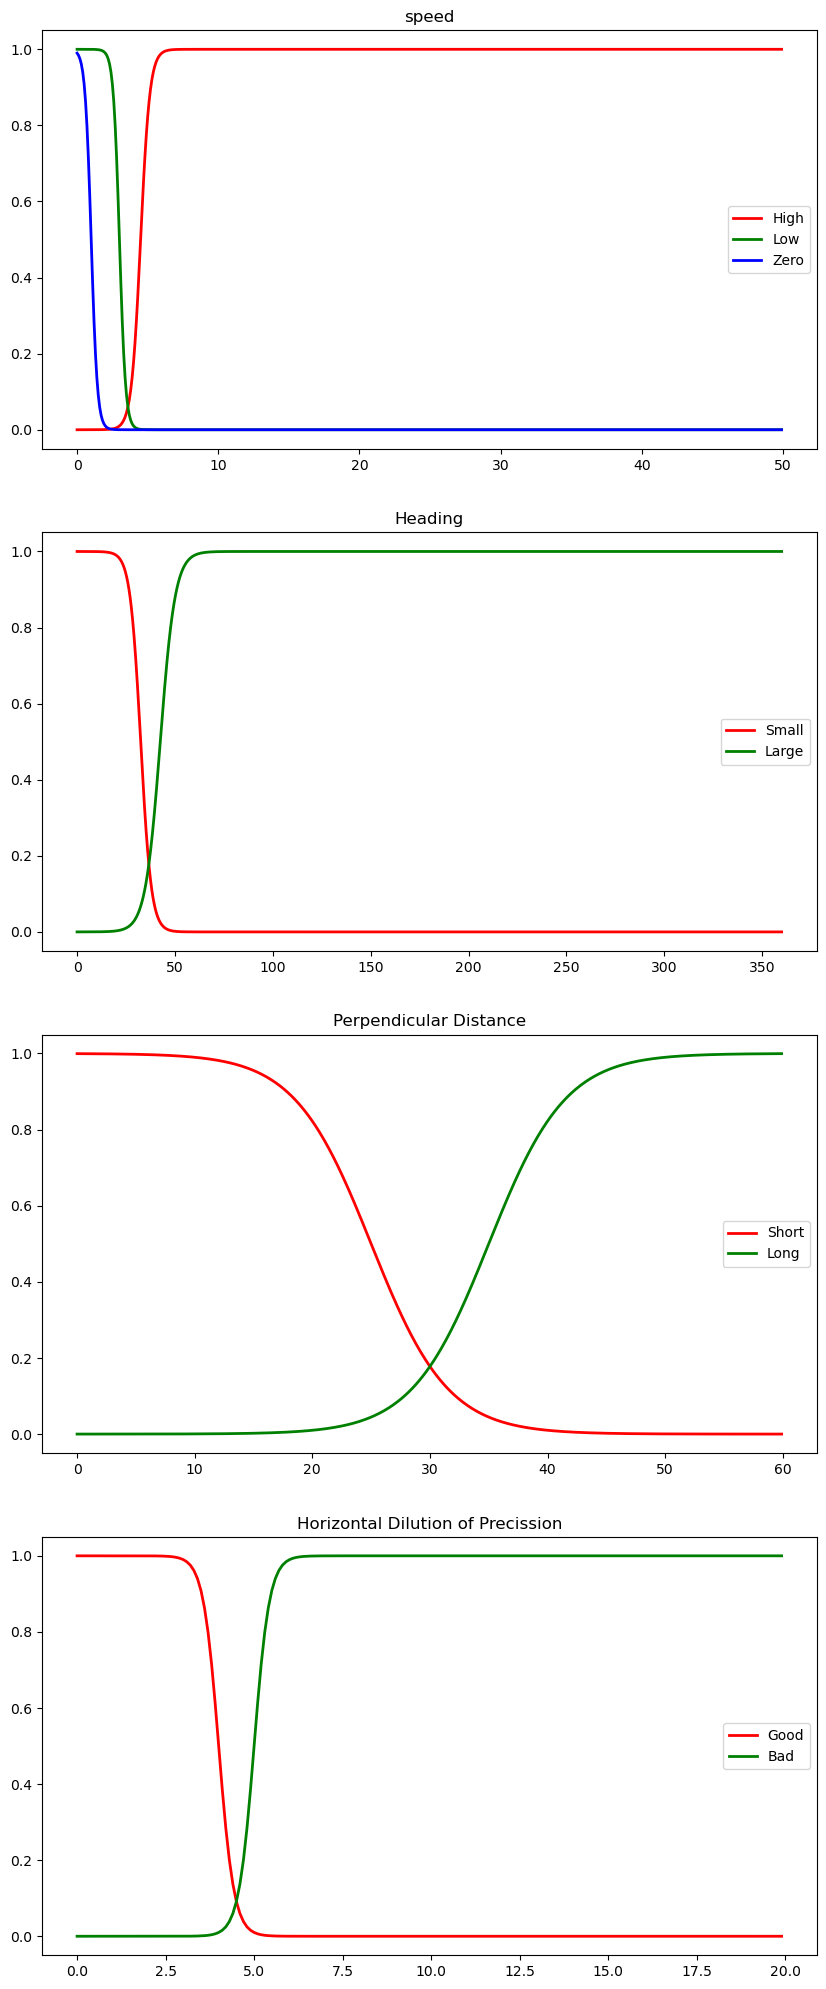

In [16]:
pred = np.zeros((1,6))

for i in range(6):
    print(FIS1(matrix_data[i,:], plot = True))


In [30]:
# function to initialize variable bounds
def init_vars():
    left_bounds = [3, 2, 0, 20, 25, 10, 20, 3, 4, 85, 90, 85, 90, -5, -5, 10, 15, 150, 0, 0, 5, 10]
    right_bounds = [6, 4, 2, 45, 60, 40, 50, 5, 6, 100, 120, 100, 120, 5, 10, 20, 30, 200, 1, 1, 15, 25]
    data = {"left_bounds": left_bounds, "right_bounds": right_bounds}
    df = pd.DataFrame(data, index=["speed_high", "speed_low", "speed_zero", "HE_small",
                                   "HE_large", "PD_short", "PD_long", "HDOP_good",
                                   "HDOP_bad", "alpha_low", "alpha_high", "beta_low", "beta_high",
                                   "delta_dist_neg", "delta_dist_pos",
                                   "HI_small", "HI_large", "HI_180", "connectivity_direct",
                                   "connectivity_indirect", "dist_err_small", "dist_err_large"])
    df["ID"] = range(1, len(df) + 1)
    return df




def get_params(l, r, shape="s"):
    shape = shape.lower()
    if shape == "s":
        y = np.array([0.01, 0.5, 0.99])
    else:
        y = np.array([0.99, 0.5, 0.01])

    x = np.array([l, (l + r) / 2, r])
    slope = 1 / (r - l)

    def logistic_func(x, a, b, c):
        return a / (1 + np.exp(-b * (x - c)))

    p0 = [1, slope, (l + r) / 2]
    params, _ = curve_fit(logistic_func, x, y, p0=p0)

    return params[1]

def get_mid(bounds, row):
    return (bounds.iloc[row, 0] + bounds.iloc[row, 1]) / 2


var_bounds = init_vars()
#print(var_bounds.iloc[0,0])
get_mid(var_bounds,0)
m = np.empty((5, 9))
m[:] = np.nan

# assign each element
m[0, 0] = 6
m[1, 0] = get_params(var_bounds.iloc[0, 0], var_bounds.iloc[0, 1], "s")
m[2, 0] = get_mid(var_bounds, 0)

m[0, 1] = 6
m[1, 1] = get_params(var_bounds.iloc[1, 0], var_bounds.iloc[1, 1], "z")
m[2, 1] = get_mid(var_bounds, 1)

m[0, 2] = 6
m[1, 2] = get_params(var_bounds.iloc[2, 0], var_bounds.iloc[2, 1], "z")
m[2, 2] = get_mid(var_bounds, 2)

m[0, 3] = 6
m[1, 3] = get_params(var_bounds.iloc[3, 0], var_bounds.iloc[3, 1], "z")
m[2, 3] = get_mid(var_bounds, 3)

m[0, 4] = 6
m[1, 4] = get_params(var_bounds.iloc[4, 0], var_bounds.iloc[4, 1], "s")
m[2, 4] = get_mid(var_bounds, 4)

m[0, 5] = 6
m[1, 5] = get_params(var_bounds.iloc[5, 0], var_bounds.iloc[5, 1], "z")
m[2, 5] = get_mid(var_bounds, 5)


m[0, 6] = 6
m[1, 6] = get_params(var_bounds.iloc[6, 0], var_bounds.iloc[6, 1], "s")
m[2, 6] = get_mid(var_bounds, 6)

m[0, 7] = 6
m[1, 7] = get_params(var_bounds.iloc[7, 0], var_bounds.iloc[7, 1], "z")
m[2, 7] = get_mid(var_bounds, 7)

m[0, 8] = 6
m[1, 8] = get_params(var_bounds.iloc[8, 0], var_bounds.iloc[8, 1], "s")
m[2, 8] = get_mid(var_bounds, 8)

# define range for each input 
x_speed = np.arange(0, 10, 0.1)
x_HE = np.arange(0, 150, 0.1)
x_PD = np.arange(0, 60, 0.1)
x_HDOP = np.arange(0, 20, 0.1)

# Creating Membership function : 
#input : range, x shift, width, 
# note : parameter input is flipped from R function 
speed_high = mf.sigmf(x_speed, m[2, 0], m[1, 0])
speed_low = mf.sigmf(x_speed, m[2, 1], m[1, 1])
speed_zero = mf.sigmf(x_speed, m[2,2], m[1,2])

HE_small = mf.sigmf(x_HE, m[2, 3], m[1, 3])
HE_large = mf.sigmf(x_HE, m[2, 4], m[1, 4])

PD_short = mf.sigmf(x_PD, m[2, 5], m[1, 5])
PD_long = mf.sigmf(x_PD, m[2, 6], m[1, 6])

HDOP_good = mf.sigmf(x_HDOP, m[2, 7], m[1, 7])
HDOP_bad = mf.sigmf(x_HDOP, m[2, 8], m[1, 8])

%matplotlib tk
# plot membership function 
fig, (ax1) = plt.subplots(nrows = 1, figsize =(10, 25))


# ax0.plot(x_speed, speed_high, 'r', linewidth = 2, label = 'High')
# ax0.plot(x_speed, speed_low, 'g', linewidth = 2, label = 'Low')
# ax0.plot(x_speed, speed_zero, 'b', linewidth = 2, label = 'Zero')
# ax0.set_title('speed')
# ax0.legend()


ax1.plot(x_HE, HE_small, 'r', linewidth = 2, label = 'Small')
ax1.plot(x_HE, HE_large, 'g', linewidth = 2, label = 'Large')
ax1.set_title('Heading')
ax1.legend()

# ax2.plot(x_PD, PD_short, 'r', linewidth = 2, label = 'Short')
# ax2.plot(x_PD, PD_long, 'g', linewidth = 2, label = 'Long')
# ax2.set_title('Perpendicular Distance')
# ax2.legend()

# ax3.plot(x_HDOP, HDOP_good, 'r', linewidth = 2, label = 'Good')
# ax3.plot(x_HDOP, HDOP_bad, 'g', linewidth = 2, label = 'Bad')
# ax3.set_title('Horizontal Dilution of Precission')
# ax3.legend()


C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
